Loaded and reformatted SIC data:
<xarray.Dataset> Size: 199MB
Dimensions:                (time: 366, y: 448, x: 304)
Coordinates:
  * time                   (time) datetime64[ns] 3kB 2020-01-01 ... 2020-12-31
  * x                      (x) float32 1kB -3.838e+06 -3.812e+06 ... 3.738e+06
  * y                      (y) float32 2kB 5.838e+06 5.812e+06 ... -5.338e+06
Data variables:
    sea_ice_concentration  (time, y, x) float32 199MB 0.0 0.0 0.0 ... 0.0 0.0
Loaded data for 10 buoys.
Interpolation complete.
No data available for Buoy cleaned_2020P174 on 2020-09-05.
No data available for Buoy cleaned_2020P177 on 2020-09-05.
No data available for Buoy cleaned_2020P176 on 2020-09-05.
No data available for Buoy cleaned_2020P172 on 2020-09-05.
Positions on 2020-09-05:
             datetime  longitude  latitude buoy_id
0 2020-09-05 00:00:00        NaN       NaN     NaN
1 2020-09-05 01:00:00        NaN       NaN     NaN
2 2020-09-05 02:00:00        NaN       NaN     NaN
3 2020-09-05 03:00:00    

/var/folders/lm/jq7cgq_91z98cg7sw6wybytw0000gn/T/ipykernel_40880/2295323829.py:160: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  hours = pd.date_range(start=start_datetime, end=end_datetime, freq='1H')
/var/folders/lm/jq7cgq_91z98cg7sw6wybytw0000gn/T/ipykernel_40880/2295323829.py:171: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  specific_day_data = specific_day_data.set_index('datetime').resample('1H').interpolate(method='linear').reset_index()
/var/folders/lm/jq7cgq_91z98cg7sw6wybytw0000gn/T/ipykernel_40880/2295323829.py:171: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  specific_day_data = specific_day_data.set_index('datetime').resample('1H').interpolate(method='linear').reset_index()
/var/folders/lm/jq7cgq_91z98cg7sw6wybytw0000gn/T/ipykernel_40880/22

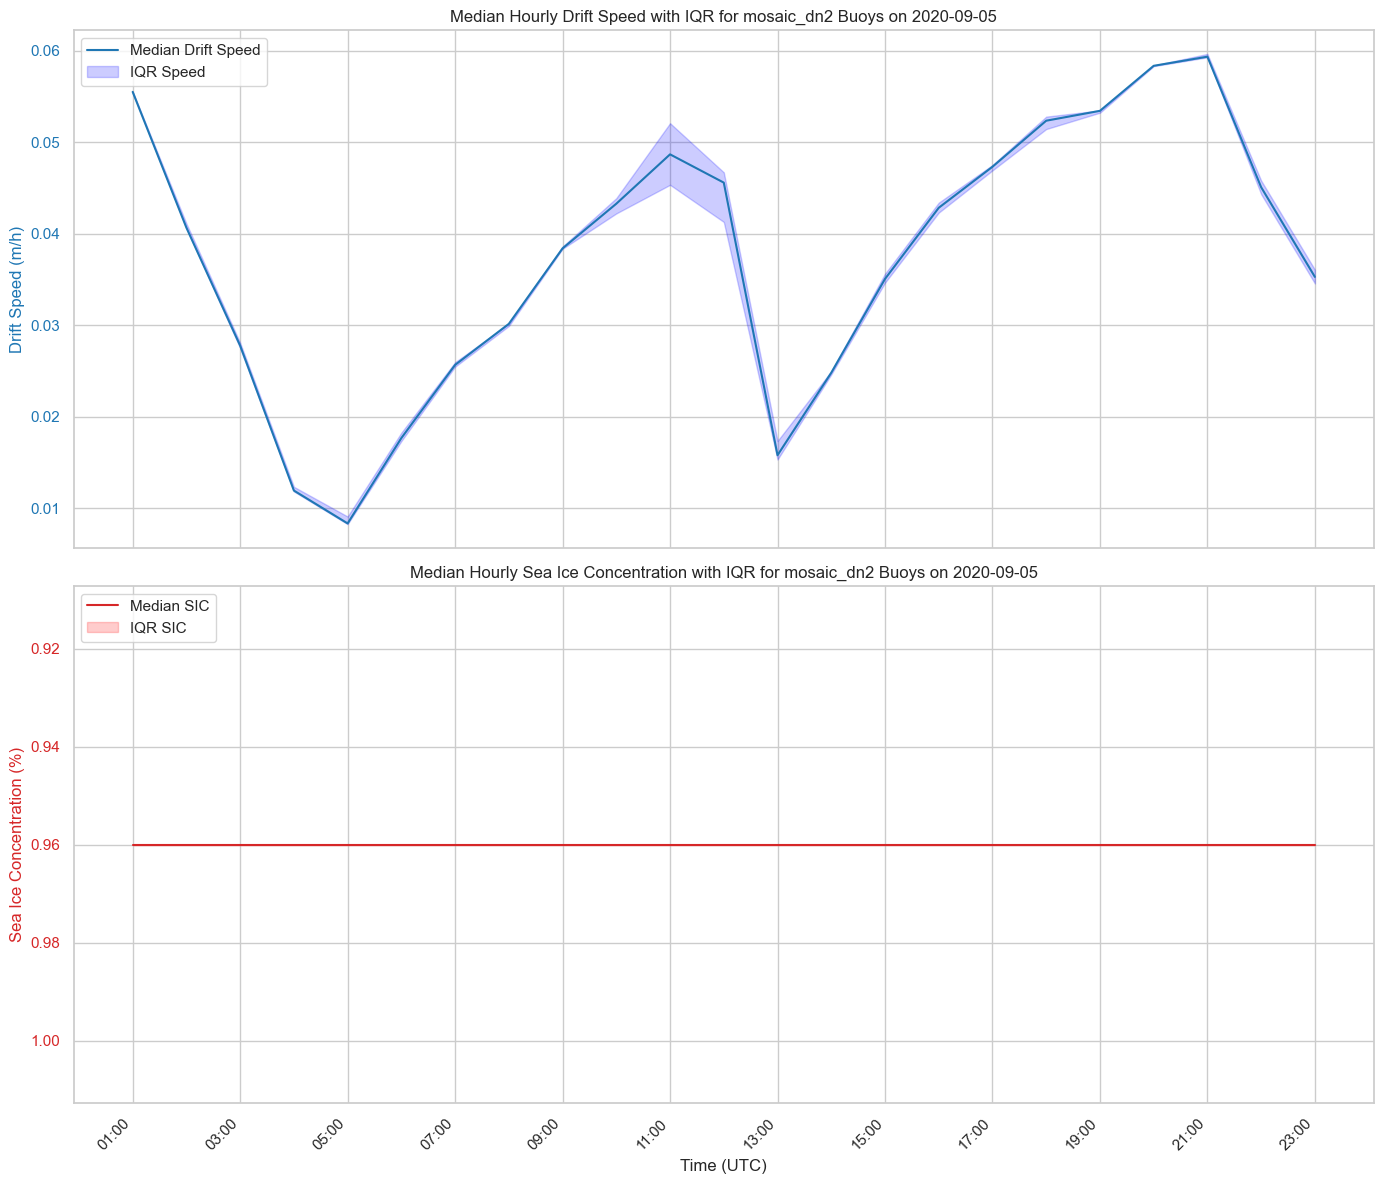

OSError: [Errno 30] Read-only file system: '/path'

In [86]:
import xarray as xr
import pandas as pd
import pyproj
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.dates as mdates

# Add the path to icedrift package if it's not already in your PYTHONPATH
sys.path.append('/Users/aless/Desktop/icedrift/src')

from icedrift.analysis import compute_velocity
from icedrift.interpolation import interpolate_buoy_track

def sic_along_track(position_data, sic_ds):
    """
    Uses xarray advanced interpolation to get along-track SIC via nearest neighbors.
    
    Parameters:
    - position_data: DataFrame with 'datetime', 'longitude', 'latitude'
    - sic_ds: xarray Dataset with 'sea_ice_concentration'
    
    Returns:
    - pandas Series with SIC values aligned to position_data index
    """
    # Define coordinate reference systems
    crs_wgs84 = pyproj.CRS('EPSG:4326')  # WGS 84
    crs_stere = pyproj.CRS(
        '+proj=stere +lat_0=90 +lat_ts=70 +lon_0=-45 '
        '+k=1 +x_0=0 +y_0=0 +a=6378273 +b=6356889.449 '
        '+units=m +no_defs'
    )
    transformer = pyproj.Transformer.from_crs(crs_wgs84, crs_stere, always_xy=True)
    
    # Initialize SIC series
    sic = pd.Series(data=np.nan, index=position_data.index)
    
    for date, group in position_data.groupby(position_data['datetime'].dt.date):
        print(f"Processing date: {date}")  # Debugging statement
        try:
            # Transform coordinates to stereographic projection
            x_stere, y_stere = transformer.transform(group['longitude'].values, group['latitude'].values)
            
            # Create DataArrays for interpolation
            x = xr.DataArray(x_stere, dims="points")
            y = xr.DataArray(y_stere, dims="points")
            
            # Select SIC data for the current date
            sic_daily = sic_ds.sel(time=date.strftime('%Y-%m-%d'))
            
            # Perform nearest neighbor interpolation
            sic_values = sic_daily['sea_ice_concentration'].interp(
                x=x,
                y=y,
                method='nearest'
            ).values
            
            # Assign SIC values to the corresponding positions
            sic.loc[group.index] = np.round(sic_values, 3)
            print(f"Assigned SIC values for date {date}")  # Debugging statement
        except KeyError:
            # Handle dates not present in SIC data
            print(f"SIC data for date {date} not found. Assigning NaN.")
            sic.loc[group.index] = np.nan
    
    # Replace SIC values greater than 100 with NaN
    sic[sic > 100] = np.nan
    return sic

# Define base directory
base_dir = '/path/to/your/project/'  # Replace with your actual base directory

# Path to mosaic_dn2 buoy data
buoy_data_dir = '../data/buoy_data/mosaic_dn2/cleaned_data/'

# Path to NetCDF SIC files
sic_data_path = os.path.join(base_dir, 'data/nsidc_sic/')  # Update if different

# Define the specific date to extract
specific_date = '2020-09-05'  # YYYY-MM-DD format

# Number of buoys to process
num_buoys = 10  # Adjust as needed

# Load SIC data
sic_file = '../NSIDC Sea Ice Concentration/nsidc_daily_sic_cdr_2020.nc'  # Update filename as needed
sic_data = xr.open_dataset(sic_file)

# Reformat NSIDC data for convenience with interpolation -- rename coordinates and dimensions
ds = xr.Dataset({
    'sea_ice_concentration': (('time', 'y', 'x'), sic_data['cdr_seaice_conc'].data)
},
coords={
    'time': ('time', pd.to_datetime(sic_data.time.data)),
    'x': ('x', sic_data['xgrid'].data),
    'y': ('y', sic_data['ygrid'].data)
})

print("Loaded and reformatted SIC data:")
print(ds)

# List all CSV files in the buoy data directory
mosaic_dn2_files = [f for f in os.listdir(buoy_data_dir) if f.endswith('.csv')]

# Select the first `num_buoys` buoys
selected_buoys = mosaic_dn2_files[:num_buoys]

# Load each CSV into a dictionary with buoy IDs as keys
# Assuming buoy ID is part of the filename, e.g., buoy1.csv, buoy2.csv, etc.
buoy_data = {}
for file in selected_buoys:
    buoy_id = os.path.splitext(file)[0]  # Removes the .csv extension
    file_path = os.path.join(buoy_data_dir, file)
    df = pd.read_csv(file_path, parse_dates=['datetime'])  # Ensure 'datetime' column exists
    buoy_data[buoy_id] = df

print(f"Loaded data for {len(buoy_data)} buoys.")

# Interpolate buoy tracks to hourly intervals
buoy_data_interp = {}

for buoy_id, df in buoy_data.items():
    # Ensure the datetime column is named 'datetime'; adjust if necessary
    if 'datetime' not in df.columns:
        df = df.rename(columns={'time': 'datetime'}) if 'time' in df.columns else df
    
    # Set datetime as the index
    df.set_index('datetime', inplace=True)
    
    # Interpolate using icedrift's interpolate_buoy_track
    interpolated = interpolate_buoy_track(df, freq='1h', maxgap_minutes=240)
    
    # Store only 'longitude' and 'latitude' columns
    buoy_data_interp[buoy_id] = interpolated[['longitude', 'latitude']]

print("Interpolation complete.")

# Filter data for the specific date
specific_date_timestamp = pd.to_datetime(specific_date)

# Define the start and end of the specific date
start_datetime = specific_date_timestamp.replace(hour=0, minute=0, second=0, microsecond=0)
end_datetime = specific_date_timestamp.replace(hour=23, minute=59, second=59, microsecond=999999)

# Initialize a dictionary to store positions on the specific date
positions_on_date = {}

for buoy_id, df in buoy_data_interp.items():
    # Extract data for the specific date
    mask = (df.index >= start_datetime) & (df.index <= end_datetime)
    specific_day_data = df.loc[mask]
    
    if specific_day_data.empty:
        print(f"No data available for Buoy {buoy_id} on {specific_date}.")
        # Create a DataFrame with NaNs for each hour
        hours = pd.date_range(start=start_datetime, end=end_datetime, freq='1H')
        specific_day_data = pd.DataFrame({
            'datetime': hours,
            'longitude': [np.nan]*len(hours),
            'latitude': [np.nan]*len(hours)
        })
    else:
        # Assign the specific_day_data to the dictionary
        specific_day_data = specific_day_data.reset_index()
        specific_day_data['buoy_id'] = buoy_id
        # Ensure all hours are present; interpolate if necessary
        specific_day_data = specific_day_data.set_index('datetime').resample('1H').interpolate(method='linear').reset_index()
    
    positions_on_date[buoy_id] = specific_day_data

# Combine all buoys into a single DataFrame
positions_df = pd.concat(positions_on_date.values(), ignore_index=True)

print(f"Positions on {specific_date}:")
print(positions_df.head())
print(positions_df.columns)

# Assign SIC values
positions_df['sea_ice_concentration'] = sic_along_track(positions_df, ds)

# Verify the column exists
print("Columns in positions_df after SIC extraction:")
print(positions_df.columns)

# Check for any missing SIC values
missing_sic = positions_df['sea_ice_concentration'].isna().sum()
print(f"Number of missing SIC values: {missing_sic}")

# Compute velocities
# Assuming you have 'longitude' and 'latitude', compute 'u', 'v', and 'speed'
# However, since it's a single day with hourly data, velocity computation might require consecutive hours
# Here's a simplified approach:

# Sort the DataFrame by buoy_id and datetime
positions_df.sort_values(['buoy_id', 'datetime'], inplace=True)

# Initialize velocity columns
positions_df['u'] = np.nan
positions_df['v'] = np.nan
positions_df['speed'] = np.nan

# Compute velocity for each buoy
for buoy_id in positions_df['buoy_id'].unique():
    buoy_subset = positions_df[positions_df['buoy_id'] == buoy_id]
    buoy_subset = buoy_subset.set_index('datetime')
    
    # Compute differences
    buoy_subset[['delta_lon', 'delta_lat']] = buoy_subset[['longitude', 'latitude']].diff()
    
    # Convert degrees to meters (approximation)
    # 1 degree latitude ≈ 111 km, 1 degree longitude ≈ 111 km * cos(latitude)
    buoy_subset['delta_lat_m'] = buoy_subset['delta_lat'] * 111000  # meters
    buoy_subset['delta_lon_m'] = buoy_subset['delta_lon'] * 111000 * np.cos(np.deg2rad(buoy_subset['latitude']))
    
    # Compute u and v (m/s)
    buoy_subset['u'] = buoy_subset['delta_lon_m'] / 3600  # m/h
    buoy_subset['v'] = buoy_subset['delta_lat_m'] / 3600  # m/h
    
    # Compute speed
    buoy_subset['speed'] = np.sqrt(buoy_subset['u']**2 + buoy_subset['v']**2)
    
    # Assign back to positions_df
    positions_df.loc[positions_df['buoy_id'] == buoy_id, 'u'] = buoy_subset['u'].values
    positions_df.loc[positions_df['buoy_id'] == buoy_id, 'v'] = buoy_subset['v'].values
    positions_df.loc[positions_df['buoy_id'] == buoy_id, 'speed'] = buoy_subset['speed'].values

# Drop rows where 'speed' is NaN (first hour)
positions_df.dropna(subset=['speed'], inplace=True)

# Calculate drift speed statistics
drift_speed_stats = positions_df.groupby('datetime').agg(
    median_speed=('speed', 'median'),
    IQR_lower_speed=('speed', lambda x: x.quantile(0.25)),
    IQR_upper_speed=('speed', lambda x: x.quantile(0.75))
).reset_index()

# Calculate sea ice concentration statistics
sic_stats = positions_df.groupby('datetime').agg(
    median_sic=('sea_ice_concentration', 'median'),
    IQR_lower_sic=('sea_ice_concentration', lambda x: x.quantile(0.25)),
    IQR_upper_sic=('sea_ice_concentration', lambda x: x.quantile(0.75))
).reset_index()

print("Drift Speed Statistics:")
print(drift_speed_stats)

print("\nSea Ice Concentration Statistics:")
print(sic_stats)

# Plotting
sns.set(style="whitegrid")

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 12), sharex=True)

# Plot Median Drift Speed
color = 'tab:blue'
ax1.set_ylabel('Drift Speed (m/h)', color=color)
ax1.plot(drift_speed_stats['datetime'], drift_speed_stats['median_speed'], label='Median Drift Speed', color=color)
ax1.fill_between(
    drift_speed_stats['datetime'],
    drift_speed_stats['IQR_lower_speed'],
    drift_speed_stats['IQR_upper_speed'],
    color="blue",
    alpha=0.2,
    label='IQR Speed'
)
ax1.tick_params(axis='y', labelcolor=color)
ax1.legend(loc='upper left')
ax1.set_title(f'Median Hourly Drift Speed with IQR for mosaic_dn2 Buoys on {specific_date}')

# Plot Median Sea Ice Concentration
color = 'tab:red'
ax2.set_ylabel('Sea Ice Concentration (%)', color=color)
ax2.plot(sic_stats['datetime'], sic_stats['median_sic'], label='Median SIC', color=color)
ax2.fill_between(
    sic_stats['datetime'],
    sic_stats['IQR_lower_sic'],
    sic_stats['IQR_upper_sic'],
    color="red",
    alpha=0.2,
    label='IQR SIC'
)
ax2.tick_params(axis='y', labelcolor=color)
ax2.legend(loc='upper left')
ax2.set_title(f'Median Hourly Sea Ice Concentration with IQR for mosaic_dn2 Buoys on {specific_date}')
ax2.invert_yaxis()  # Adjust based on data interpretation

# Customize the x-axis to show hourly times
ax2.xaxis.set_major_locator(mdates.HourLocator(interval=2))  # Major ticks every 2 hours
ax2.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))  # Format as 'Hour:Minute'

# Optional: Minor ticks every hour
ax2.xaxis.set_minor_locator(mdates.HourLocator())

# Rotate x-axis labels for better readability
plt.setp(ax2.xaxis.get_majorticklabels(), rotation=45, ha='right')

# Common X-axis label
plt.xlabel('Time (UTC)')

# Adjust layout to prevent overlap
plt.tight_layout()

# Display the plot
plt.show()

# Save the figure
figures_dir = os.path.join(base_dir, 'figures')
os.makedirs(figures_dir, exist_ok=True)

fig.savefig(os.path.join(figures_dir, f'mosaic_dn2_median_drift_speed_IQR_{specific_date}.png'))
plt.close()

print(f"Figure saved to {os.path.join(figures_dir, f'mosaic_dn2_median_drift_speed_IQR_{specific_date}.png')}")


In [ ]:
import xarray as xr
import pandas as pd
import pyproj
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# Add the path to icedrift package if it's not already in your PYTHONPATH
# Replace the path below with the actual path to your icedrift package
sys.path.append('/Users/aless/Desktop/icedrift/src')

from icedrift.analysis import compute_velocity, compute_absolute_dispersion, compute_along_across_components
from icedrift.interpolation import interpolate_buoy_track  # Ensure icedrift is accessible


In [ ]:

# Path to mosaic_dn2 buoy data
mosaic_dn2_data_dir = '../data/buoy_data/mosaic_dn2/cleaned_data/'

# Path to NetCDF SIC files
sic_file =  '../NSIDC Sea Ice Concentration/nsidc_daily_sic_cdr_2020.nc'  # Update filename as needed

# Define the specific date to extract
specific_date = '2020-09-05'  # YYYY-MM-DD format

# Number of buoys to process
num_buoys = 10  # Adjust as needed



In [ ]:
def sic_along_track(position_data, sic_ds):
    """
    Uses xarray advanced interpolation to get along-track SIC via nearest neighbors.
    
    Parameters:
    - position_data: DataFrame with 'datetime', 'longitude', 'latitude'
    - sic_ds: xarray Dataset with 'sea_ice_concentration'
    
    Returns:
    - pandas Series with SIC values aligned to position_data index
    """
    # Define coordinate reference systems
    crs_wgs84 = pyproj.CRS('EPSG:4326')  # WGS 84
    crs_stere = pyproj.CRS(
        '+proj=stere +lat_0=90 +lat_ts=70 +lon_0=-45 '
        '+k=1 +x_0=0 +y_0=0 +a=6378273 +b=6356889.449 '
        '+units=m +no_defs'
    )
    transformer = pyproj.Transformer.from_crs(crs_wgs84, crs_stere, always_xy=True)
    
    # Initialize SIC series
    sic = pd.Series(data=np.nan, index=position_data.index)
    
    for date, group in position_data.groupby(position_data['datetime'].dt.date):
        print(f"Processing date: {date}")  # Debugging statement
        try:
            # Transform coordinates to stereographic projection
            x_stere, y_stere = transformer.transform(group['longitude'].values, group['latitude'].values)
            
            # Create DataArrays for interpolation
            x = xr.DataArray(x_stere, dims="points")
            y = xr.DataArray(y_stere, dims="points")
            
            # Select SIC data for the current date
            sic_daily = sic_ds.sel(time=date.strftime('%Y-%m-%d'))
            
            # Perform nearest neighbor interpolation
            sic_values = sic_daily['sea_ice_concentration'].interp(
                x=x,
                y=y,
                method='nearest'
            ).values
            
            # Assign SIC values to the corresponding positions
            sic.loc[group.index] = np.round(sic_values, 3)
            print(f"Assigned SIC values for date {date}")  # Debugging statement
        except KeyError:
            # Handle dates not present in SIC data
            print(f"SIC data for date {date} not found. Assigning NaN.")
            sic.loc[group.index] = np.nan
    
    # Replace SIC values greater than 100 with NaN
    sic[sic > 100] = np.nan
    return sic



In [ ]:
# Load SIC data
sic_file =  '../NSIDC Sea Ice Concentration/nsidc_daily_sic_cdr_2020.nc'  # Update filename as needed
sic_data = xr.open_dataset(sic_file)

# Reformat NSIDC data for convenience with interpolation -- rename coordinates and dimensions
ds = xr.Dataset({
    'sea_ice_concentration': (('time', 'y', 'x'), sic_data['cdr_seaice_conc'].data)
},
coords={
    'time': ('time', pd.to_datetime(sic_data.time.data)),
    'x': ('x', sic_data['xgrid'].data),
    'y': ('y', sic_data['ygrid'].data)
})

print("Loaded and reformatted SIC data:")
print(ds)



Loaded and reformatted SIC data:
<xarray.Dataset> Size: 199MB
Dimensions:                (time: 366, y: 448, x: 304)
Coordinates:
  * time                   (time) datetime64[ns] 3kB 2020-01-01 ... 2020-12-31
  * x                      (x) float32 1kB -3.838e+06 -3.812e+06 ... 3.738e+06
  * y                      (y) float32 2kB 5.838e+06 5.812e+06 ... -5.338e+06
Data variables:
    sea_ice_concentration  (time, y, x) float32 199MB 0.0 0.0 0.0 ... 0.0 0.0


In [ ]:
# List all CSV files in the buoy data directory
mosaic_dn2_files = [f for f in os.listdir('../data/buoy_data/mosaic_dn2/cleaned_data/') if f.endswith('.csv')]

# Select the first `num_buoys` buoys
selected_buoys = mosaic_dn2_files[:num_buoys]

# Load each CSV into a dictionary with buoy IDs as keys
# Assuming buoy ID is part of the filename, e.g., buoy1.csv, buoy2.csv, etc.
buoy_data = {}
for file in selected_buoys:
    buoy_id = os.path.splitext(file)[0]  # Removes the .csv extension
    file_path = os.path.join('../data/buoy_data/mosaic_dn2/cleaned_data/', file)
    df = pd.read_csv(file_path, parse_dates=['datetime'])  # Ensure 'datetime' column exists
    buoy_data[buoy_id] = df

print(f"Loaded data for {len(buoy_data)} buoys.")


Loaded data for 10 buoys.


In [ ]:
# Initialize a dictionary to store interpolated buoy data
buoy_data_interp = {}

for buoy_id, df in buoy_data.items():
    # Ensure the datetime column is named 'datetime'; adjust if necessary
    if 'datetime' not in df.columns:
        df = df.rename(columns={'time': 'datetime'}) if 'time' in df.columns else df
    
    # Set datetime as the index
    df.set_index('datetime', inplace=True)
    
    # Interpolate using icedrift's interpolate_buoy_track
    interpolated = interpolate_buoy_track(df, freq='1h', maxgap_minutes=240)
    
    # Store only 'longitude' and 'latitude' columns
    buoy_data_interp[buoy_id] = interpolated[['longitude', 'latitude']]

print("Interpolation complete.")


Interpolation complete.


In [ ]:
# Convert specific_date to pandas Timestamp
specific_date_timestamp = pd.to_datetime(specific_date)

# Define the start and end of the specific date
start_datetime = specific_date_timestamp.replace(hour=0, minute=0, second=0, microsecond=0)
end_datetime = specific_date_timestamp.replace(hour=23, minute=59, second=59, microsecond=999999)

# Initialize a dictionary to store positions on the specific date
positions_on_date = {}

for buoy_id, df in buoy_data_interp.items():
    # Extract data for the specific date
    mask = (df.index >= start_datetime) & (df.index <= end_datetime)
    specific_day_data = df.loc[mask]
    
    if specific_day_data.empty:
        print(f"No data available for Buoy {buoy_id} on {specific_date}.")
        positions_on_date[buoy_id] = pd.DataFrame({
            'datetime': [specific_date_timestamp],
            'longitude': [np.nan],
            'latitude': [np.nan]
        })
    else:
        # Assign the specific_day_data to the dictionary
        specific_day_data = specific_day_data.reset_index()
        specific_day_data['buoy_id'] = buoy_id
        positions_on_date[buoy_id] = specific_day_data

# Combine all buoys into a single DataFrame
positions_df = pd.concat(positions_on_date.values(), ignore_index=True)

print(f"Positions on {specific_date}:")
print(positions_df.head())
print(positions_df.columns)


No data available for Buoy cleaned_2020P174 on 2020-09-05.
No data available for Buoy cleaned_2020P177 on 2020-09-05.
No data available for Buoy cleaned_2020P176 on 2020-09-05.
No data available for Buoy cleaned_2020P172 on 2020-09-05.
Positions on 2020-09-05:
             datetime  longitude  latitude           buoy_id
0 2020-09-05 00:00:00        NaN       NaN               NaN
1 2020-09-05 00:00:00  119.81504  88.74786  cleaned_2020P175
2 2020-09-05 01:00:00  119.73336  88.74810  cleaned_2020P175
3 2020-09-05 02:00:00  119.67578  88.74849  cleaned_2020P175
4 2020-09-05 03:00:00  119.63883  88.74886  cleaned_2020P175
Index(['datetime', 'longitude', 'latitude', 'buoy_id'], dtype='object')


Buoy nan has no position data on 2020-09-05.


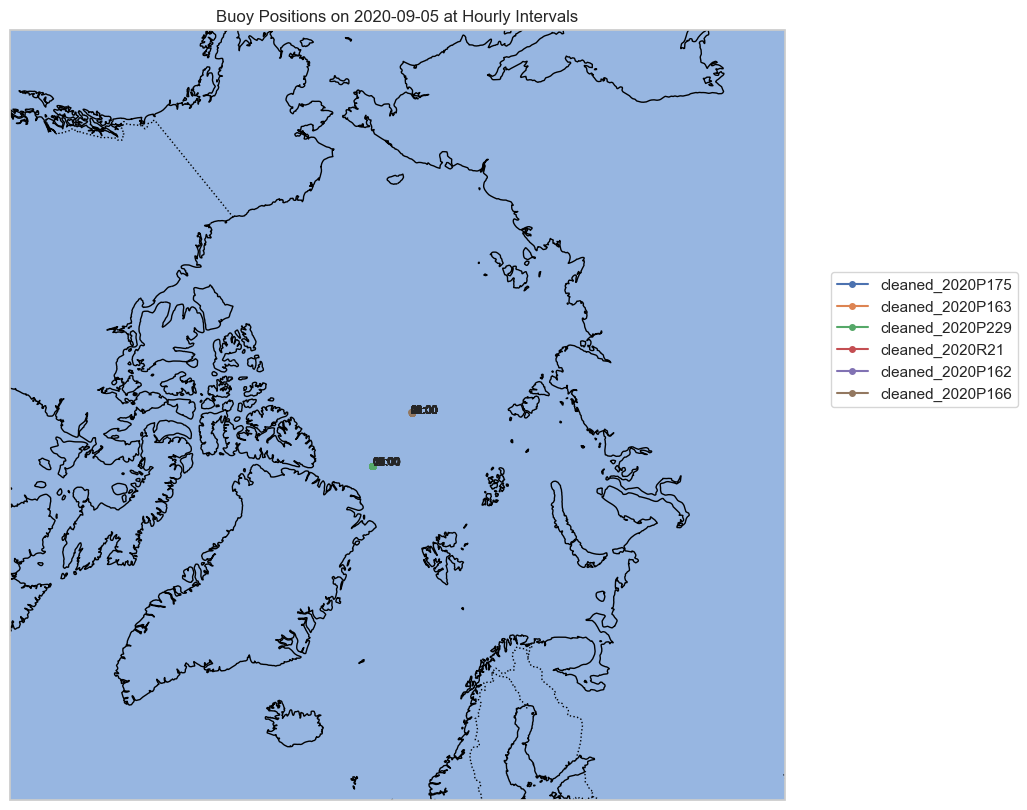

In [ ]:
# Initialize the map
plt.figure(figsize=(12, 10))
ax = plt.axes(projection=ccrs.NorthPolarStereo())
ax.set_extent([-180, 180, 60, 90], crs=ccrs.PlateCarree())

# Add features
ax.add_feature(cfeature.LAND, zorder=0, edgecolor='black')
ax.add_feature(cfeature.OCEAN, zorder=0)
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS, linestyle=':')

# Plot each buoy's position throughout the day
for buoy_id in positions_df['buoy_id'].unique():
    buoy_data = positions_df[positions_df['buoy_id'] == buoy_id]
    
    # Drop rows with NaN positions
    buoy_data = buoy_data.dropna(subset=['longitude', 'latitude'])
    
    if buoy_data.empty:
        print(f"Buoy {buoy_id} has no position data on {specific_date}.")
        continue
    
    ax.plot(
        buoy_data['longitude'],
        buoy_data['latitude'],
        marker='o',
        markersize=4,
        label=buoy_id,
        transform=ccrs.PlateCarree()
    )
    
    # Optionally, add annotations at specific times
    for _, row in buoy_data.iterrows():
        ax.text(
            row['longitude'] + 0.1,
            row['latitude'] + 0.1,
            row['datetime'].strftime('%H:%M'),
            fontsize=8,
            transform=ccrs.PlateCarree()
        )

plt.title(f'Buoy Positions on {specific_date} at Hourly Intervals')
plt.legend(loc='lower left', bbox_to_anchor=(1.05, 0.5))
plt.show()


In [ ]:
# Concatenate all buoy data into a single DataFrame
all_positions_daily = pd.concat(buoy_data_daily.values())

# Reset index to make 'datetime' a column
all_positions_daily.reset_index(inplace=True)

print("Combined all buoys into all_positions_daily.")
print(all_positions_daily.head())
print(all_positions_daily.columns)


Combined all buoys into all_positions_daily.
             datetime  longitude  latitude           buoy_id             x  \
0 2020-09-07 10:00:00  113.02481  88.67278  cleaned_2020P174  53803.338627   
1 2020-09-08 10:00:00  113.92376  88.65043  cleaned_2020P174  52575.609233   
2 2020-09-09 10:00:00  112.81181  88.70422  cleaned_2020P174  53012.276209   
3 2020-09-10 10:00:00  108.21487  88.69338  cleaned_2020P174  63788.261003   
4 2020-09-11 10:00:00  105.29920  88.72809  cleaned_2020P174  68269.946206   

               y         u         v     speed  
0  133334.135049       NaN       NaN       NaN  
1  136421.289922 -0.004578 -0.019415  0.019948  
2  129979.195675  0.064888 -0.058221  0.087179  
3  126360.770205  0.088297 -0.059567  0.106511  
4  119686.074052  0.050401 -0.075194  0.090523  
Index(['datetime', 'longitude', 'latitude', 'buoy_id', 'x', 'y', 'u', 'v',
       'speed'],
      dtype='object')


In [ ]:
# Extract SIC values and add to all_positions_daily
all_positions_daily['sea_ice_concentration'] = sic_along_track(all_positions_daily, ds)

# Verify the column exists
print("Columns in all_positions_daily after SIC extraction:")
print(all_positions_daily.columns)

# Check for any missing SIC values
missing_sic = all_positions_daily['sea_ice_concentration'].isna().sum()
print(f"Number of missing SIC values: {missing_sic}")


Processing date: 2020-08-19
Assigned SIC values for date 2020-08-19
Processing date: 2020-08-20
Assigned SIC values for date 2020-08-20
Processing date: 2020-08-21
Assigned SIC values for date 2020-08-21
Processing date: 2020-08-22
Assigned SIC values for date 2020-08-22
Processing date: 2020-08-23
Assigned SIC values for date 2020-08-23
Processing date: 2020-08-24
Assigned SIC values for date 2020-08-24
Processing date: 2020-08-25
Assigned SIC values for date 2020-08-25
Processing date: 2020-08-26
Assigned SIC values for date 2020-08-26
Processing date: 2020-08-27
Assigned SIC values for date 2020-08-27
Processing date: 2020-08-28
Assigned SIC values for date 2020-08-28
Processing date: 2020-08-29
Assigned SIC values for date 2020-08-29
Processing date: 2020-08-30
Assigned SIC values for date 2020-08-30
Processing date: 2020-08-31
Assigned SIC values for date 2020-08-31
Processing date: 2020-09-01
Assigned SIC values for date 2020-09-01
Processing date: 2020-09-02
Assigned SIC values 

In [ ]:
# Interpolate missing 'speed' values
all_positions_daily['speed'] = all_positions_daily['speed'].interpolate(method='linear')

# Forward fill any remaining NaNs
all_positions_daily['speed'] = all_positions_daily['speed'].fillna(method='ffill').fillna(method='bfill')

# Check the total number of NaNs in the 'speed' column
total_speed_nans = all_positions_daily['speed'].isna().sum()
print(f"Total NaN values in 'speed': {total_speed_nans}")

# Identify datetime groups where all 'speed' values are NaN
speed_nan_groups = all_positions_daily.groupby('datetime')['speed'].apply(lambda x: x.isna().all())
nan_dates = speed_nan_groups[speed_nan_groups].index.tolist()

print(f"Dates with all 'speed' values as NaN: {nan_dates}")

# Display rows where 'speed' is NaN
nan_speed_rows = all_positions_daily[all_positions_daily['speed'].isna()]
print("Rows with NaN 'speed' values:")
print(nan_speed_rows)


Total NaN values in 'speed': 0
Dates with all 'speed' values as NaN: []
Rows with NaN 'speed' values:
Empty DataFrame
Columns: [datetime, longitude, latitude, buoy_id, x, y, u, v, speed, sea_ice_concentration]
Index: []


/var/folders/lm/jq7cgq_91z98cg7sw6wybytw0000gn/T/ipykernel_40880/941635688.py:5: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  all_positions_daily['speed'] = all_positions_daily['speed'].fillna(method='ffill').fillna(method='bfill')


In [ ]:
# Set the plot style
sns.set(style="whitegrid")

# Calculate drift speed statistics
drift_speed_stats = all_positions_daily.groupby('datetime').agg(
    median_speed=('speed', 'median'),
    IQR_lower_speed=('speed', lambda x: x.quantile(0.25)),
    IQR_upper_speed=('speed', lambda x: x.quantile(0.75))
).reset_index()

# Calculate sea ice concentration statistics
sic_stats = all_positions_daily.groupby('datetime').agg(
    median_sic=('sea_ice_concentration', 'median'),
    IQR_lower_sic=('sea_ice_concentration', lambda x: x.quantile(0.25)),
    IQR_upper_sic=('sea_ice_concentration', lambda x: x.quantile(0.75))
).reset_index()

print("Statistical calculations complete.")
print(drift_speed_stats)
print(sic_stats)


Statistical calculations complete.
                datetime  median_speed  IQR_lower_speed  IQR_upper_speed
0    2020-08-19 13:00:00      0.057534         0.057534         0.057534
1    2020-08-20 13:00:00      0.010951         0.010951         0.010951
2    2020-08-21 13:00:00      0.013855         0.013855         0.013855
3    2020-08-22 13:00:00      0.070033         0.070033         0.070033
4    2020-08-23 13:00:00      0.124399         0.124399         0.124399
...                  ...           ...              ...              ...
1634 2021-05-22 13:00:00      0.206505         0.206505         0.206505
1635 2021-05-23 08:00:00      0.071081         0.071081         0.071081
1636 2021-05-23 09:00:00      0.102509         0.102509         0.102509
1637 2021-05-23 10:00:00      0.104118         0.104118         0.104118
1638 2021-05-23 13:00:00      0.174005         0.174005         0.174005

[1639 rows x 4 columns]
                datetime  median_sic  IQR_lower_sic  IQR_upper_s